# 0 Utils

In [384]:
import os
import numpy as np
import seaborn as sb
%matplotlib inline
# sb.set()
import matplotlib.pyplot as plt
import pandas as pd
import shap


In [385]:
N_JOBS = 4 # -1 ocupa todo los cores
RANDOM_STATE = 42 # para que sea reproducible

## Experiment Setting 

In [386]:
# dataset, base nro 2
dataset_nro = 8
experiment_nro = 1
# 'All Proyects', 'Altos del Valle', 'Edificio Urban 1470','San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'
proyecto_select = 'San Andres Del Valle' #cambiable

# base, base_profesion, base_minusisprofesion, base_medini_isrec
use_predictors = 'no_is_time_price' #cambiable
# experimento 2 y 4 va con True
no_nulls = False #cambiable
sesgo = False #cambiable

In [387]:
predictors_set = dict()

no_is_time_price = [
    'is_recontacto', 'is_remoto', 'is_descuento', 'valid_rut',
    'loc_comuna', 'loc_provincia', 'loc_region', 'sexo', 'tipo_cliente','mean_cot_bod',
    'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'medio_inicial',
    'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta',
    'nro_cot_estu', 'nro_proyectos', 'precio_cotizacion_media',
    'precio_cotizacion_median', 'precio_cotizacion_std', 
    'tiempo_cotizacion_media', 'tiempo_cotizacion_median',
    'tiempo_cotizacion_std',   
    'Altos del Valle',
    'Edificio Urban 1470', 
#     'San Andres Del Valle', 
    'Edificio Mil610',
       'Edificio Junge']

predictors_set ['no_is_time_price'] = no_is_time_price



# 1 Load Dataset

In [388]:
# nombre experimento
exp_name = "{} {}".format(proyecto_select, use_predictors)
# eleccion dataset
dataset = 'personas_cotizacion{}.csv'.format(dataset_nro)

# DS_NAME = dataset.split('.')[0]
DS_NAME = exp_name

directory = '..\\results\\model_results_dataset{}'.format(dataset_nro)
import os
if not os.path.exists(directory):
    os.makedirs(directory)

folder = '..\\results\\model_results_dataset{}\\{}'.format(dataset_nro, DS_NAME)

if not os.path.exists(folder):
    os.mkdir(folder)


personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")
personas_view = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")
readme = dict()
readme['experiment_name'] = DS_NAME
readme['experiment_dataset'] = dataset

print(personas.shape)
readme['personas_shape'] = personas.shape
# personas.head(2)

print(personas.columns)
readme['personas_columns'] = personas.columns.tolist()

(6155, 47)
Index(['Unnamed: 0', 'actividad', 'compra', 'is_apellido1', 'is_apellido2',
       'is_celular', 'is_descuento', 'is_direccion', 'is_fnac', 'is_nombre',
       'is_nombrecompleto', 'is_nrofam', 'is_presencial', 'is_profesion',
       'is_recontacto', 'is_remoto', 'is_telefono', 'loc_comuna',
       'loc_provincia', 'loc_region', 'max_rango_edad', 'mean_cot_bod',
       'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'medio_inicial',
       'negocio', 'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta',
       'nro_cot_estu', 'nro_proyectos', 'precio_cotizacion_media',
       'precio_cotizacion_median', 'precio_cotizacion_std', 'rut', 'sexo',
       'tiempo_cotizacion_media', 'tiempo_cotizacion_median',
       'tiempo_cotizacion_std', 'tipo_cliente', 'valid_rut', 'Altos del Valle',
       'Edificio Urban 1470', 'San Andres Del Valle', 'Edificio Mil610',
       'Edificio Junge'],
      dtype='object')


In [389]:
personas['loc_comuna'] = personas['loc_comuna'].astype('category')
personas['loc_provincia'] = personas['loc_provincia'].astype('category')
personas['loc_region'] = personas['loc_region'].astype('category')
personas['tipo_cliente'] = personas['tipo_cliente'].astype('category')
personas['sexo'] = personas['sexo'].astype('category')
# personas.profesion.fillna('sin informacion', inplace=True)
# personas['profesion'] = personas['profesion'].astype('category')
personas['medio_inicial'] = personas['medio_inicial'].astype('category')

predictors = predictors_set[use_predictors]

# UNDER/OVER-SAMPLING

In [390]:
#COMPRA
p_i = personas.copy(deep=True)
p_i = p_i[p_i['San Andres Del Valle'] > 0]



Class 0: 3564
Class 1: 235
Proportion: 15.17 : 1


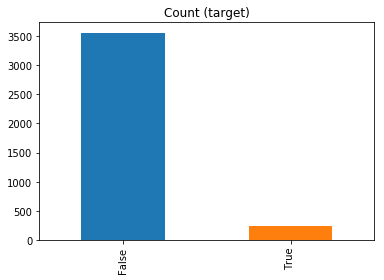

In [391]:
target_count = p_i.compra.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Class 0: 2968
Class 1: 831
Proportion: 3.57 : 1


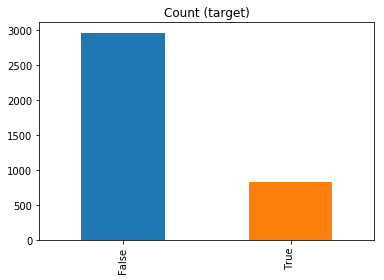

In [392]:
#NEGOCIO
target_count = p_i.negocio.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [393]:
# Class count
count_class_0, count_class_1 = p_i.compra.value_counts()

# Divide by class
df_class_0 = p_i[p_i.compra == 0]
df_class_1 = p_i[p_i.compra == 1]

Random under-sampling:
True     235
False    235
Name: compra, dtype: int64


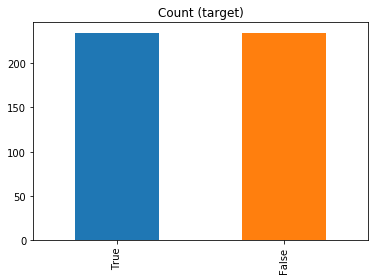

In [394]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.compra.value_counts())

df_test_under.compra.value_counts().plot(kind='bar', title='Count (target)');

Random over-sampling:
True     3564
False    3564
Name: compra, dtype: int64


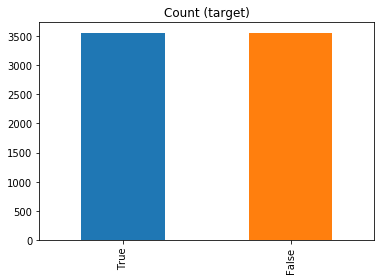

In [395]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.compra.value_counts())

df_test_over.compra.value_counts().plot(kind='bar', title='Count (target)');

# SKLEARN IMBALANCE

In [396]:
y = p_i.compra
p_i = p_i[predictors]
X = pd.get_dummies(p_i)

In [397]:
import imblearn

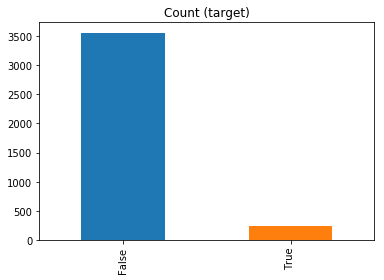

In [398]:
from sklearn.datasets import make_classification

# X, y = make_classification(
#     n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
#     n_informative=3, n_redundant=1, flip_y=0,
#     n_features=20, n_clusters_per_class=1,
#     n_samples=100, random_state=10
# )


# df = pd.DataFrame(X)
# df['target'] = y


df = X
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

In [315]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

# Imbalanced dataset (2 PCA components)
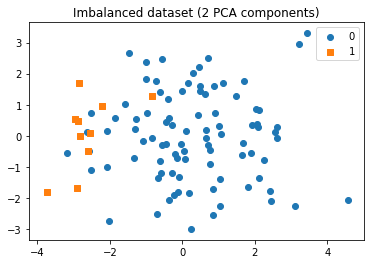

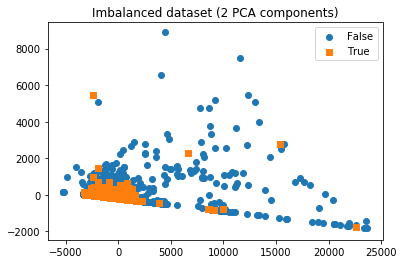

In [316]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2)
# X = tsne.fit_transform(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

# Random under-sampling
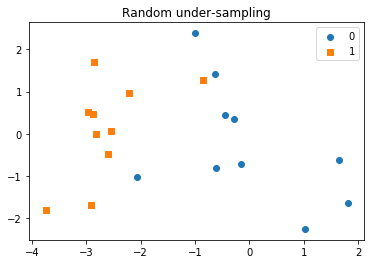

In [399]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print(X_rus.shape, y_rus.shape)
print('Removed indexes:', len(id_rus))

# plot_2d_space(X_rus, y_rus, 'Random under-sampling')

(470, 56) (470,)
Removed indexes: 470


# Random over-sampling
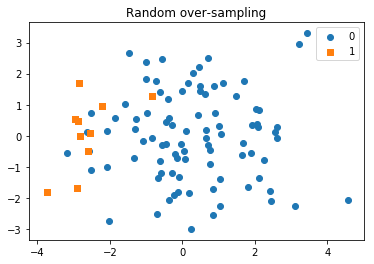

In [400]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape, y_ros.shape)
print(X_ros.shape[0] - X.shape[0], 'new random picked points')

# plot_2d_space(X_ros, y_ros, 'Random over-sampling')

(7128, 56) (7128,)
3329 new random picked points


# Under-sampling: Tomek links
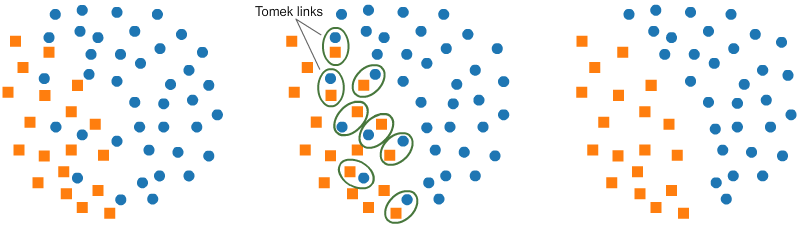

In [401]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print(X_tl.shape, y_tl.shape)
print('Removed indexes:', len(id_tl))

# plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

(3701, 56) (3701,)
Removed indexes: 3701


# Under-sampling: Cluster Centroids
This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.

In this example we will pass the {0: 10} dict for the parameter ratio, to preserve 10 elements from the majority class (0), and all minority class (1) .
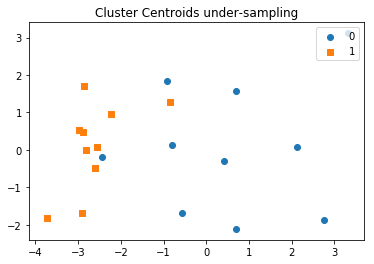

In [402]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 100})
X_cc, y_cc = cc.fit_sample(X, y)
print(X_cc.shape, y_cc.shape)
# plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

(335, 56) (335,)


# Over-sampling: SMOTE
SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.
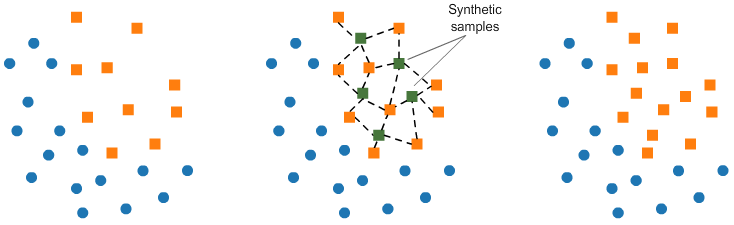

In [403]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

print(X_sm.shape, y_sm.shape)
# plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

(7128, 56) (7128,)


# Over-sampling followed by under-sampling
Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:
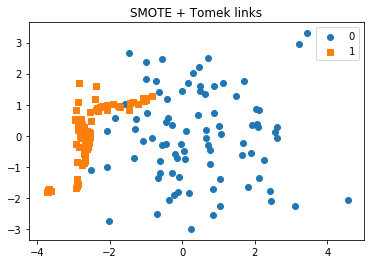

In [411]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

# plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

# NORMAL DATA

In [115]:
# Ajustes especificos experimento
# Para E5D5, E6D5 #########################################
if proyecto_select != 'All Proyects':
    mask = (personas[proyecto_select] > 0)
    personas = personas[mask]
    print(personas[mask].shape)
    personas[mask]
###########################################################

predictors = predictors_set[use_predictors]

# En que experimento use esto? E8D6 y E28D6
# Se usa en los experimentos de data set limpio para evaluar con las personas que si entregaron la profesion
if no_nulls:
    personas.replace(['sin informacion'], np.nan, inplace=True)
    personas.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


(3799, 47)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [123]:
print(predictors)
# Ready Data Set
p_negocio = personas.compra # Target
p_negocio = pd.Series([0 if x == True else 1 for x in p_negocio.tolist()])
# personas = personas.drop(drop_columns, axis=1) # Predictors
personas = personas[predictors]

print(p_negocio.shape)
print(personas.shape)
readme['personas_after_drop_columns'] = personas.columns

print(personas.shape)
readme['personas_predictors_shape'] = personas.shape
readme['personas_predictors'] = personas.columns


personas = pd.get_dummies(personas)
readme['personas_dummies_shape'] = personas.shape

# personas.describe()

['is_recontacto', 'is_remoto', 'is_descuento', 'valid_rut', 'loc_comuna', 'loc_provincia', 'loc_region', 'sexo', 'tipo_cliente', 'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'medio_inicial', 'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos', 'precio_cotizacion_media', 'precio_cotizacion_median', 'precio_cotizacion_std', 'tiempo_cotizacion_media', 'tiempo_cotizacion_median', 'tiempo_cotizacion_std', 'Altos del Valle', 'Edificio Urban 1470', 'Edificio Mil610', 'Edificio Junge']
(3799,)
(3799, 29)
(3799, 29)


# 3 Supervised Learning: Classification

## 3.1 Libraries

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

## 3.2 Check the Dataset

In [125]:
print("Tamaño Total: ", personas.shape)
print("Personas que hicieron Negocio: ", p_negocio[p_negocio == True].shape)
print("Personas que no Hicieorn Negocio: ", p_negocio[p_negocio == False].shape)
readme['personas_negocio'] = p_negocio[p_negocio == True].shape
readme['personas_nonegocio'] = p_negocio[p_negocio == False].shape

Tamaño Total:  (3799, 55)
Personas que hicieron Negocio:  (3564,)
Personas que no Hicieorn Negocio:  (235,)


In [121]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# transformer = SelectKBest(score_func=chi2,k=10)
# Xt_chi2 = transformer.fit_transform(X,y)
# print(Xt_chi2.shape)
# print(transformer.scores_)

## 3.3 Train & Test

In [ ]:
X = personas
y = p_negocio

In [404]:
X = X_cc
y = y_cc

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
readme['x_train_shape'] = X_train.shape
readme['y_train_shape'] = y_train.shape
readme['x_test_shape'] = X_test.shape
readme['y_test_shape'] = y_test.shape

(234, 56) (101, 56) (234,) (101,)


## 3.4 Help Functions

In [406]:
import scikitplot as skplt

def classifier_insights(y_test, clf_probas, MODEL):
    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_cumulative_gain(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
    plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_cum_gain.png'.format(dataset_nro, DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
    plt.show()


    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_lift_curve(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
    plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_lift.png'.format(dataset_nro, DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
    plt.show()

    fig = plt.figure()
    ax = plt.subplot(skplt.estimators.plot_feature_importances(
        best_brf, feature_names=personas.columns, x_tick_rotation=90, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
    plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_f_importance.png'.format(dataset_nro, DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
    plt.show()



    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_precision_recall(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
    plt.savefig('..//results/model_results_dataset{}\\{}\\{}_precition_recall.png'.format(dataset_nro, DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
    plt.show()

    fig = plt.figure()
    ax = plt.subplot(skplt.metrics.plot_ks_statistic(y_test, clf_probas, figsize=(12,8)))
    plt.legend(loc=9, bbox_to_anchor=(1.15, 1), ncol=1)
    plt.savefig('..//results/model_results_dataset{}/\\{}\\{}_ks_sta.png'.format(dataset_nro, DS_NAME, MODEL), bbox_inches = 'tight', dpi=300)
    plt.show()

In [407]:
import json
def save_readme():    
    exDict = {'readme': readme}
    with open('..\\results\\model_results_dataset{}\\{}\\readme_{}.txt'.format(dataset_nro, DS_NAME, DS_NAME), 'w') as file:
        file.write(str(exDict))

def plot_all_auc_values():
        
    d = dict()
    for key in roc_curves_to_plot[DS_NAME]:
        d[key] = roc_curves_to_plot[DS_NAME][key]['auc']
    
    s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    
    x_model = [x[0] for x in s]
    x_value = [x[1] for x in s]
    
    x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
    f = plt.figure(figsize=(12,8))
    plt.title('{} AUC Models'.format(DS_NAME))
    plt.xlabel('Models')
    plt.ylabel('AUC')
    plt.bar(x, x_value)
    plt.xticks(x, x_model)
    plt.savefig('..\\results\\model_results_dataset{}\\{}\\auc_models.png'.format(dataset_nro, DS_NAME,DS_NAME), dpi=300)
    plt.show()

def plot_all_roc_curves():
    
    f = plt.figure(figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    for key in roc_curves_to_plot[DS_NAME]:
        plt.plot(roc_curves_to_plot[DS_NAME][key]['fpr'], roc_curves_to_plot[DS_NAME][key]['tpr']) #fpr and tpr
    
    legends = ['random choice']
    legends.extend(roc_curves_to_plot[DS_NAME].keys())
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
    plt.savefig('..\\results\\model_results_dataset{}\\{}\\roc_curve_all.png'.format(dataset_nro, DS_NAME, MODEL), dpi=300)
    plt.show()

In [408]:
# Import necessary modules
def plot_importance_graph(model):
    features = personas.columns
    
    feature_importance = model.best_estimator_.feature_importances_ 
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(feature_importance, columns=["importance"])
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))

    index = np.arange(len(feature_importance[:20]))
    bar_width = 0.5
    rects = plt.barh(index[:20] , df_f["importance"][:20], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.title("{} {} Feature Importance".format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results_dataset{}\\{}\\{}_importance.png'.format(dataset_nro, DS_NAME, MODEL), dpi=300)
    plt.show()
    
def roc_curve_plot(model, X_test, y_test):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,0]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)
    
    roc_curves_to_plot[DS_NAME][MODEL] = dict()
    roc_curves_to_plot[DS_NAME][MODEL]['fpr'] = fpr
    roc_curves_to_plot[DS_NAME][MODEL]['tpr'] = tpr
    roc_curves_to_plot[DS_NAME][MODEL]['auc'] = roc_auc_score(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} {} ROC Curve'.format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results_dataset{}\\{}\\{}_roc_curve.png'.format(dataset_nro, DS_NAME, MODEL), dpi=300)
    plt.show()

import itertools
def plot_confusion_matrix(model, y, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig = plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def grid_results(grid, plot_roc_curve=True):
    
    best_model = grid.best_estimator_
    
    try:
        best_score = grid.best_score_
        print("Besto Model Best score is {}".format(grid.best_score_))
    except Exception as e:
        print("Error: " + str(e))
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    # Confusion Matrix
    plot_confusion_matrix(best_model, y_test, y_pred, ['Compra', 'No Compra'])
        
    #ROC Curve
    if plot_roc_curve:
        roc_curve_plot(best_model, X_test, y_test)

## 3.5 Models

In [417]:
clases = ['Compra', 'No Compra']

In [409]:
to_profit_curve = dict()

Tuned Logistic Regression Parameters: {'C': 3.727593720314938, 'penalty': 'l1'}
Best Estimator:  LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Besto Model Best score is 1.0
Confusion matrix, without normalization


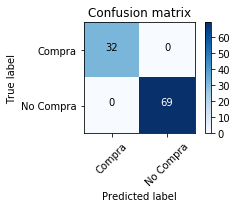

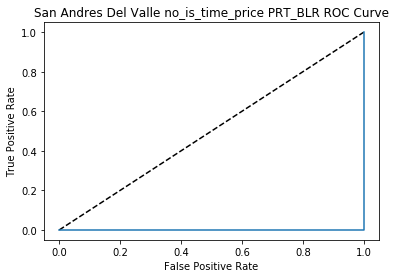

ROC AUC Score: 1.0


In [410]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
C = np.logspace(0, 4, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(class_weight=None)
# logreg = LogisticRegression()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the GridSearchCV object: logreg_cv
grid_logreg = GridSearchCV(logreg, param_grid, cv=kf, n_jobs=N_JOBS)
grid_logreg.fit(X, y)

# # Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_logreg.best_params_))
print('Best Estimator: ', grid_logreg.best_estimator_)
# print("Best score is {}".format(logreg_cv.best_score_))
# Fit it to the data
grid_results(grid_logreg)
# # 
y_pred_prob = grid_logreg.predict_proba(X_test)[:,1]

print("ROC AUC Score:" ,roc_auc_score(y_test,y_pred_prob))

Accuracy: 0.9702970297029703
             precision    recall  f1-score   support

      False       0.91      1.00      0.96        32
       True       1.00      0.96      0.98        69

avg / total       0.97      0.97      0.97       101

Confusion matrix, without normalization


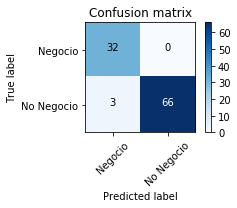

Normalized confusion matrix


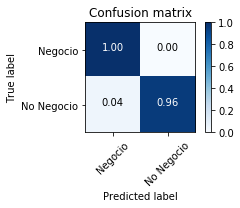

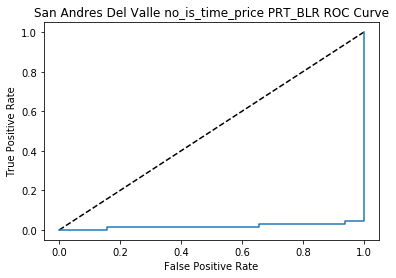

In [413]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

log_clf = LogisticRegression(C=0.4393970560760795, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

log_clf.fit(X_train, y_train)

score = log_clf.score(X_test, y_test)
print('Accuracy:', score)
y_pred = log_clf.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(log_clf, y_test, y_pred, clases, normalize=False)
plot_confusion_matrix(log_clf, y_test, y_pred, clases, normalize=True)
roc_curve_plot(log_clf, X_test, y_test)

Besto Model Best score is 0.7014925373134329
Confusion matrix, without normalization


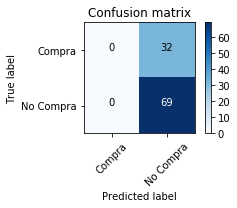

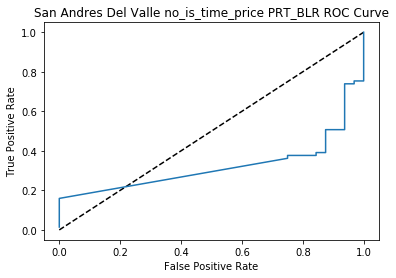

In [414]:
from sklearn import svm, grid_search

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

grid_svm = GridSearchCV(svm.SVC(kernel='rbf', probability=True), param_grid, cv=5, n_jobs=-1)

grid_svm.fit(X, y)
grid_results(grid_svm)

In [415]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# fit model no training data
xgb_clf = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# xgb_grid = GridSearchCV(xgb_clf, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
xgb_grid = GridSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=kfold, verbose=1)
xgb_grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   14.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6, 8], 'n_estimators': [50, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

Besto Model Best score is 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization


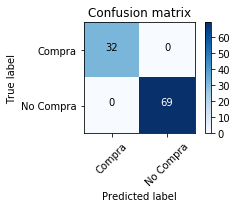

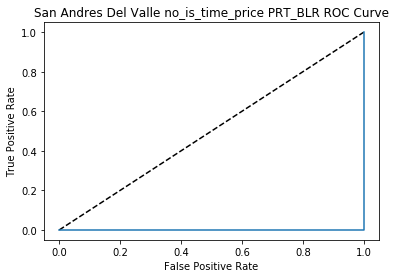

In [416]:
grid_results(xgb_grid)